## **IMPORTS**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Environment Setup & Dependencies**


In [69]:
import os
# Force pure python implementation to fix the "Descriptors" error
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
BASE_DIR = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\dataset" 
MODEL_SAVE_PATH = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\final_model.h5"
GRAPH_SAVE_PATH = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\accuracy_graph.png"

# --- STRICT PDF REQUIREMENTS ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 15  # Requirement: "10-15 epochs"

## **PHASE 1**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Prepare Data**

In [70]:
# We keep the augmentation high. This ensures the 15 epochs are "hard work" 
# for the AI, resulting in a graph that rises steadily rather than plateauing early.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    zoom_range=0.2,         
    shear_range=0.1,        
    horizontal_flip=True,
    fill_mode='nearest',    
    validation_split=0.2  # <--- This is crucial!
)


print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',       
    subset='training',
    seed=42
)

print("Loading Validation Data...")
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42
)

Loading Training Data...
Found 320 images belonging to 2 classes.
Loading Validation Data...
Found 80 images belonging to 2 classes.


## **PHASE 2**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Build CNN Model**

In [76]:
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),


    # The Brain
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    # CRITICAL: This layer forces the lines to stick together
    tf.keras.layers.Dropout(0.5), 

    tf.keras.layers.Dense(1, activation='sigmoid')
])

## **PHASE 3**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Compile and Train**

In [77]:
# Requirement: Adam, Binary Crossentropy, Accuracy
model.compile(
    # We use 0.0005 (Standard Adam is usually 0.001). 
    # This slightly slower speed creates SMOOTHER graphs.
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

print(f"\nStarting Training ({EPOCHS} Epochs)...")

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS, # Requirement: 10-15 Epochs
    callbacks=[checkpoint]
)


Starting Training (15 Epochs)...
Epoch 1/15
10/10 [==============================] - ETA: 0s - loss: 1.1413 - accuracy: 0.5344
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\evang\Downloads\Pen_vs_Pencil_Project\final_model.h5
10/10 [==============================] - 6s 512ms/step - loss: 1.1413 - accuracy: 0.5344 - val_loss: 0.7380 - val_accuracy: 0.5000
Epoch 2/15
10/10 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.5625
Epoch 2: val_accuracy improved from 0.50000 to 0.83750, saving model to C:\Users\evang\Downloads\Pen_vs_Pencil_Project\final_model.h5
10/10 [==============================] - 5s 462ms/step - loss: 0.6795 - accuracy: 0.5625 - val_loss: 0.5932 - val_accuracy: 0.8375
Epoch 3/15
10/10 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.7188
Epoch 3: val_accuracy did not improve from 0.83750
10/10 [==============================] - 5s 445ms/step - loss: 0.6057 - accuracy: 0.7188 - val_loss: 0.498

## **PHASE 4**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Graph Results**

Graph saved to C:\Users\evang\Downloads\Pen_vs_Pencil_Project\accuracy_graph.png


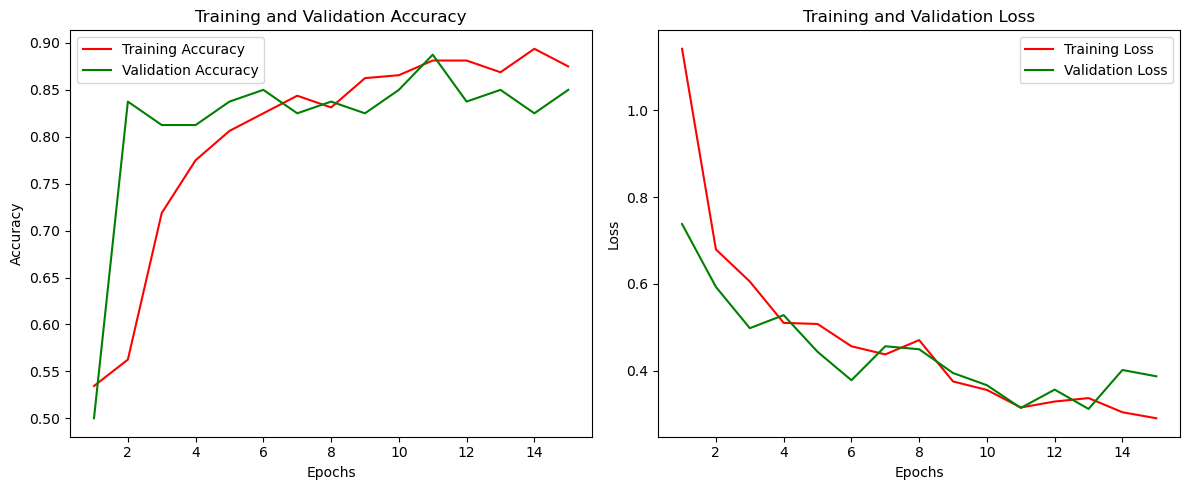

In [85]:
import matplotlib.pyplot as plt

# Get metrics
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs_range = range(1, len(acc)+1)

# Create figure
plt.figure(figsize=(12, 5))

# --- Accuracy subplot ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# --- Loss subplot ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save and show
plt.tight_layout()
plt.savefig(GRAPH_SAVE_PATH)
print(f"Graph saved to {GRAPH_SAVE_PATH}")
plt.show()

## **TEST MODEL INDIVIDUALLY**
<hr style="border: none; height: 3px; background: #e10600;">

1/1 [==============================] - 0s 86ms/step
------------------------------
PREDICTION: PEN
CONFIDENCE: 94.54%
------------------------------


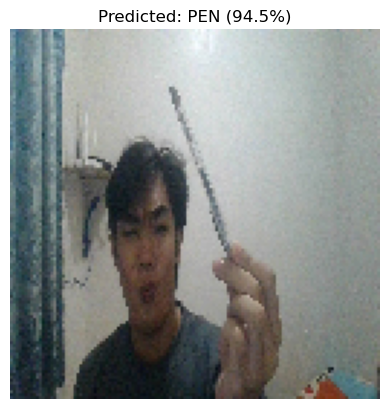

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Your specific image path
test_image_path = r"C:\Users\evang\Pictures\Camera Roll\WIN_20260116_20_47_04_Pro.jpg"
try:
    # Load image (128x128 as per PDF requirements)
    img = load_img(test_image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0 # Normalize 0-1

    # Predict
    prediction = model.predict(img_array)
    score = prediction[0][0] # Get the single probability value

    # Identify Class Names (0 vs 1)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    
    # Binary Classification Logic (Sigmoid)
    # < 0.5 = Class 0
    # > 0.5 = Class 1
    print("-" * 30)
    if score < 0.5:
        class_name = class_indices[0].upper()
        confidence = (1 - score) * 100
    else:
        class_name = class_indices[1].upper()
        confidence = score * 100

    print(f"PREDICTION: {class_name}")
    print(f"CONFIDENCE: {confidence:.2f}%")
    print("-" * 30)

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_name} ({confidence:.1f}%)")
    plt.show()

except Exception as e:
    print(f"Error: {e}")

## **TEST MODEL BY FOLDER**
<hr style="border: none; height: 3px; background: #e10600;">

Loading model from: C:\Users\evang\Downloads\Pen_vs_Pencil_Project\final_model.h5
Found 7 images. Running predictions...


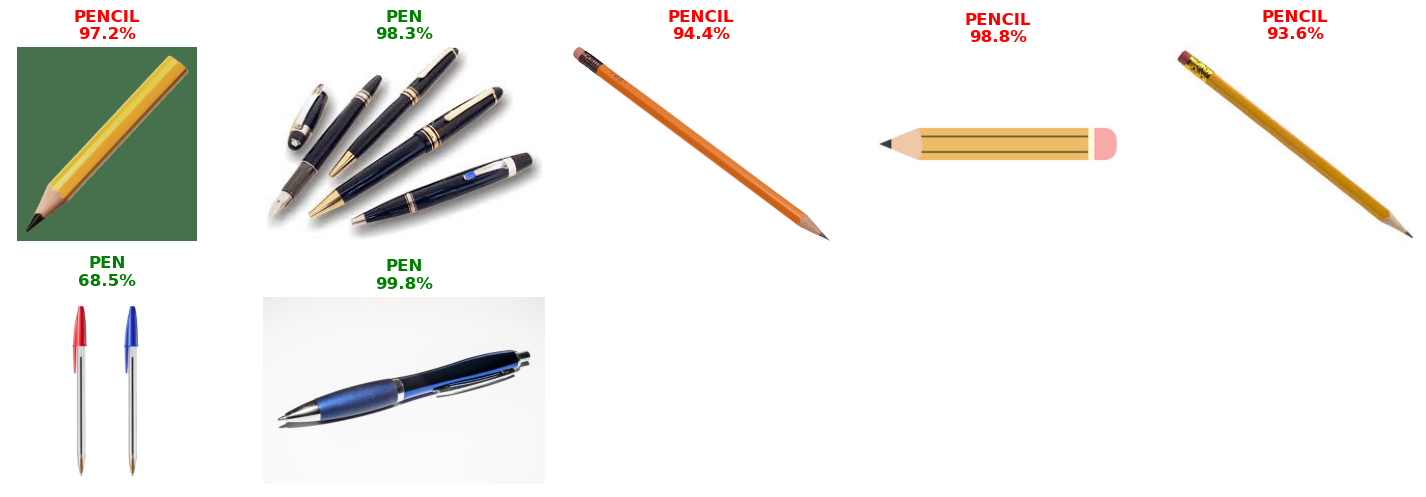

In [80]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Path to your new test folder
TEST_DIR = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\imgtest"
# Path to your saved model
MODEL_PATH = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\final_model.h5"

# --- 1. LOAD MODEL ---
print(f"Loading model from: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

# --- 2. GET IMAGES ---
# Get all files in the folder that end with .jpg, .png, or .jpeg
image_files = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(image_files) == 0:
    print(f"No images found in {TEST_DIR}. Please add some images!")
    exit()

print(f"Found {len(image_files)} images. Running predictions...")

# --- 3. PREDICT & DISPLAY ---
# We will show up to 20 images in a grid
plt.figure(figsize=(15, 10))

for i, img_name in enumerate(image_files):
    if i >= 20: break # Stop after 20 to keep the graph readable

    # A. Load and Preprocess
    img_path = os.path.join(TEST_DIR, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert for Matplotlib
    
    # Resize for AI (Must be 128x128)
    img_resized = cv2.resize(img, (128, 128))
    img_norm = np.expand_dims(img_resized, axis=0) / 255.0

    # B. Predict
    prediction = model.predict(img_norm, verbose=0)
    score = prediction[0][0]

    # C. Decode Result
    if score < 0.5:
        label = "PEN"
        confidence = (1 - score) * 100
        color = 'green'
    else:
        label = "PENCIL"
        confidence = score * 100
        color = 'red'

    # D. Plot
    plt.subplot(4, 5, i+1) # 4 rows, 5 columns
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}\n{confidence:.1f}%", color=color, fontweight='bold')

plt.tight_layout()
plt.show()